### Libraries

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import random
import pickle

### Thoughts on Strategy Employed
<ol>
    <li>The problem requires prediction for a number of days for every store-item pair in the test dataset. Any model developed will be evaluated on the quality of its predictions. Symmetric Mean Absolute Percentage Error (SMAPE) is the metric to use for the evaluation.
    <li>There are, in effect, 500 different timeseries in the train (and test) dataset - one for each store-item pair and predictions need to be made for each of these timeseries. There are 4 possible strategies, <i>in decreasing order of computing power required</i>, to build models and make predictions:
        <ul>
            <li>Build 500 different models, one for each for the store-item pair and then use a model to make predictions for the corresponding series in the test dataset.
            <li>Build 50 different models, one for each item. In this strategy, a model for a item is built by aggregating the daily sales for all stores. Then use every model to make predictions for the corresponding 10 timeseries for the respective item in the test dataset.
            <li>Build 10 different models, one for each store. In this strategy, a model for a store is built by aggregating the daily sales for all items. Then use every model to make predictions for the corresponding 50 timeseries for the respective store in the test dataset. In other words, we build a separate model for each store but apply the same model to all the 50 item series of a store.
            <li>Build a single model. In this strategy, a model is built by aggregating the daily sales for all items across all stores. Then use the model to make predictions for the 500 timeseries in the test dataset.
        </ul>
    <li>We divide the train dataset into to subsets - train and validation. The train subset will be used to build the required models, where as the validation subset will be used to compare the results across the differnt strategies. We divide the train dataset in the ratio 90:10.
    <li>To keep the computing effort manageable, 2 out of the 10 strores and 5 of the 50 items will be randomly chosen, yielding 10 store-item pair combinations. Models under strategies 1 and 2 above will be built only for the relevant store-item pairs or items and predictions under all strategies will be made for only these 10 timeseries. Average SMAPE value across the 10 timeseries will be used to compare the efficacy of the 4 proposed strategies.
</ol>    

### Get Data

In [127]:
train = pd.read_csv('./data/train.csv')

# Typecasting data
train.date = pd.to_datetime(train.date, format = '%Y-%m-%d')     
train.store = train.store.astype('category')
train.item = train.item.astype('category')
# Log Transform Sales
#train.sales = np.log(train.sales)

random.seed(1970)
stores = random.sample(range(11), 2)    # Choosing 2 of the 10 stores randonly
items = random.sample(range(51), 5)     # Choosing 5 of the 50 items randomly

In [125]:
n_train = np.int(0.9*len(train.date.unique()))                   # The ratio to split the date range
dates = train.date.unique()
trg_dates = dates[:n_train]  # List of dates to include in train subset
val_dates = dates[n_train:]  # List of dates to inclide in val subset

'''trg_idx = []
for date in trg_dates:
    idx = train.groupby('date').get_group(date).index
    trg_idx.append(idx)
trg_idx = list(itertools.chain(*trg_idx))               # List of element indices to include in train subset

val_idx = []
for date in val_dates:
    idx = train.groupby('date').get_group(date).index
    val_idx.append(idx)
    
val_idx = list(itertools.chain(*val_idx))               # List of element indices to include in val subset

with open('./data/trg_idx', 'wb') as handle:            # Saving the idx's for future use
    pickle.dump(trg_idx, handle)
with open('./data/val_idx', 'wb') as handle:
    pickle.dump(val_idx, handle)'''

"trg_idx = []\nfor date in trg_dates:\n    idx = train.groupby('date').get_group(date).index\n    trg_idx.append(idx)\ntrg_idx = list(itertools.chain(*trg_idx))               # List of element indices to include in train subset\n\nval_idx = []\nfor date in val_dates:\n    idx = train.groupby('date').get_group(date).index\n    val_idx.append(idx)\n    \nval_idx = list(itertools.chain(*val_idx))               # List of element indices to include in val subset\n\nwith open('./data/trg_idx', 'wb') as handle:            # Saving the idx's for future use\n    pickle.dump(trg_idx, handle)\nwith open('./data/val_idx', 'wb') as handle:\n    pickle.dump(val_idx, handle)"

In [130]:
dailysales = train.query('date <= @trg_dates[-1]').groupby('date')['sales'].sum()
dailysales.index = pd.DatetimeIndex(dailysales.index.values, freq = 'D')
#dailysales_df = dailysales.diff().dropna().diff(7).dropna()
dailysales_df = dailysales.diff(7).dropna()

Strategy 4 - Investigating Stationarity

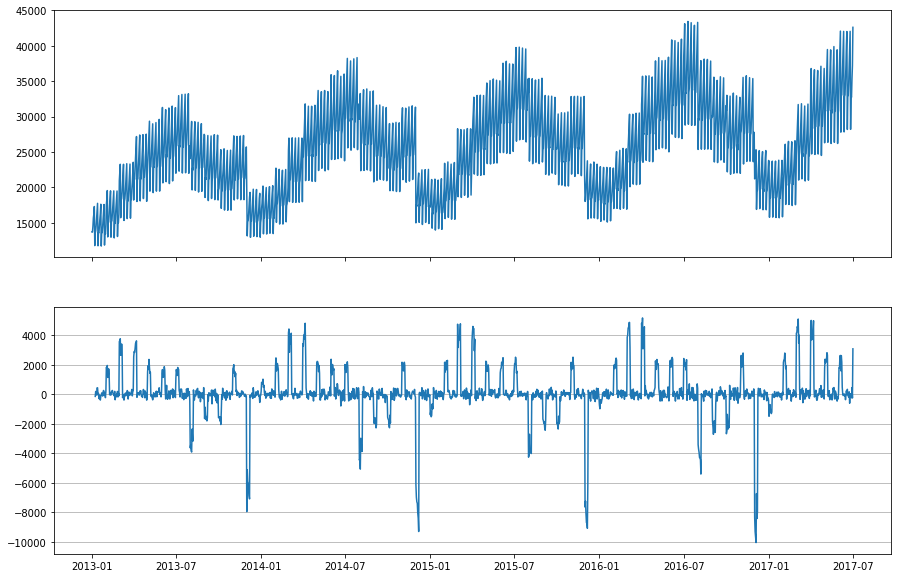

ADF test statistic: -5.9510
Critical Values for ADF test statistic
Conf. Int.    Value
   1%        -3.4344
   5%        -2.8633
  10%        -2.5677

p-value: 2.1468e-07


In [131]:
#dailysales = train.loc[trg_idx].groupby('date')['sales'].sum()

fig, ax = plt.subplots(nrows = 2, figsize = (15, 10), sharex = True)
ax[0].plot(dailysales)
ax[1].plot(dailysales_df)
plt.grid(b = True, axis = 'y')
plt.show()

result = adfuller(dailysales_df)
print("ADF test statistic: %0.4f" % result[0])
print("Critical Values for ADF test statistic")
print("Conf. Int.    Value")
for _, (key, value) in enumerate(result[4].items()):
    print("  %3s        %0.4f" % (key, value))
print("\np-value: %0.4e" % result[1])

Strategy 4 - Investigating Existence of Autocorrelation

In [35]:
result = acorr_ljungbox(dailysales_df, lags = 10, return_df = True)
print('The p-value for the Ljung-Box test statistic for the first 10 lags:')
print(result.lb_pvalue.head(10))

The p-value for the Ljung-Box test statistic for the first 10 lags:
1     3.922548e-03
2     1.289363e-02
3     1.195001e-02
4     1.899005e-02
5     3.424471e-02
6     4.775071e-02
7     1.405413e-85
8     7.245954e-85
9     4.989063e-84
10    3.070389e-83
Name: lb_pvalue, dtype: float64


Strategy 4 - Investigating ACF and PACF

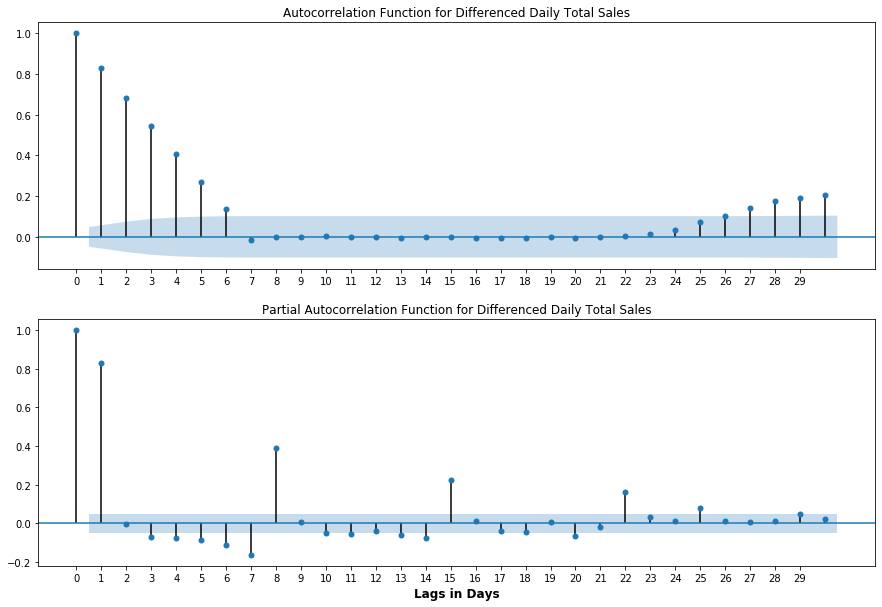

In [132]:
# Explicitly setting the DatetimeIndex frequency

#dailysales_df.index = pd.DatetimeIndex(dailysales_df.index.values, freq = 'D')

fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (15, 10))

tsaplots.plot_acf(dailysales_df, ax = ax1, alpha = 0.05, lags = 30, 
                  title = 'Autocorrelation Function for Differenced Daily Total Sales')
tsaplots.plot_pacf(dailysales_df, ax = ax2, alpha = 0.05, lags = 30,
                   title = 'Partial Autocorrelation Function for Differenced Daily Total Sales')

ax1.set_xticks(np.arange(0, 30, 1))
ax2.set_xticks(np.arange(0, 30, 1))
ax2.set_xlabel('Lags in Days', fontsize = '12', fontweight = 'bold')

plt.show()

### SARIMA Model Parameters - Grid Search

The exploratory data analysis helps us set up the following grid for the transformed timeseries:
<ol>
    <li>MA params: p = 0, 1, 2 and P = 0, 1
    <li>AR params: q = 0, 1, 2 and Q = 0, 1
    <li>d = D = 1
    <li>s = 7
</ol>

In [57]:
# Set the parameter grid
p = range(0, 3)
d = range(1, 2)
q = range(0, 3)
P = range(0, 2)
D = range(1, 2)
Q = range(0, 2)
s = range(7, 8)

# Forming the grid
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))

# SARIMA model pipeline
for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(dailysales, order = param, seasonal_order = seasonal_param)
            results = model.fit(method = 'powell')
            print('SARIMA{},{} - AIC:{}'.format(param, seasonal_param, results.aic))
        except:
            continue


Optimization terminated successfully.
         Current function value: 8.214306
         Iterations: 1
         Function evaluations: 10
SARIMA(0, 1, 0),(0, 1, 0, 7) - AIC:26994.20866261243
Optimization terminated successfully.
         Current function value: 8.040728
         Iterations: 2
         Function evaluations: 43
SARIMA(0, 1, 0),(0, 1, 1, 7) - AIC:26425.832222918463
Optimization terminated successfully.
         Current function value: 8.093694
         Iterations: 1
         Function evaluations: 22
SARIMA(0, 1, 0),(1, 1, 0, 7) - AIC:26599.877454892216
Optimization terminated successfully.
         Current function value: 8.039608
         Iterations: 3
         Function evaluations: 106
SARIMA(0, 1, 0),(1, 1, 1, 7) - AIC:26424.15113483252
Optimization terminated successfully.
         Current function value: 8.211353
         Iterations: 1
         Function evaluations: 21
SARIMA(0, 1, 1),(0, 1, 0, 7) - AIC:26986.50736546373
Optimization terminated successfully.
         

Strategy 4 : Best results: SARIMA(2, 1, 1),(1, 1, 1, 7) - AIC:26376.81599986652

In [58]:
model = SARIMAX(dailysales, order = (2, 1, 1), seasonal_order = (1, 1, 1, 7)).fit(method = 'powell')
model.summary()

Optimization terminated successfully.
         Current function value: 8.023377
         Iterations: 4
         Function evaluations: 279


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             sales   No. Observations:                 1643
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -13182.408
Date:                           Mon, 13 Apr 2020   AIC                          26376.816
Time:                                   16:54:19   BIC                          26409.212
Sample:                               01-01-2013   HQIC                         26388.833
                                    - 07-01-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8343      0.024     34.353      0.000       0.787       0.882
ar.L2          0.0511      0.022      2.378      0.017       0.009       0.093
ma.L1         -0.9630      0.016    -58.563      0.000      -0.995      -0.931
ar.S.L7       -0.0906      0.025     -3.687      0.000      -0.139      -0.042
ma.S.L7       -0.5526      0.026    -21.503      0.000      -0.603      -0.502
sigma2      5.826e+05   5291.519    110.106      0.000    5.72e+05    5.93e+05
===================================================================================
Ljung-Box (Q):                       49.83   Jarque-Bera (JB):             60971.20
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               1.46   Skew:                            -1.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [73]:
display(stores, items)

[2, 3]

[22, 7, 44, 46, 49]

In [89]:
series_222 = pd.Series(data = train.query('date <= @trg_dates[-1] & store == 2 & item == 22').loc[:, 'sales'].to_list(), index = dailysales.index)

In [97]:
series_222_model = model.apply(series_222)
series_222_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1643
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -12356.826
Date:                           Mon, 13 Apr 2020   AIC                          24725.652
Time:                                   17:27:42   BIC                          24758.049
Sample:                               01-01-2013   HQIC                         24737.669
                                    - 07-01-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8343      0.024     34.353      0.000       0.787       0.882
ar.L2          0.0511      0.022      2.378      0.017       0.009       0.093
ma.L1         -0.9630      0.016    -58.563      0.000      -0.995      -0.931
ar.S.L7       -0.0906      0.025     -3.687      0.000      -0.139      -0.042
ma.S.L7       -0.5526      0.026    -21.503      0.000      -0.603      -0.502
sigma2      5.826e+05   5291.519    110.106      0.000    5.72e+05    5.93e+05
===================================================================================
Ljung-Box (Q):                      541.94   Jarque-Bera (JB):                 0.94
Prob(Q):                              0.00   Prob(JB):                         0.62
Heteroskedasticity (H):               1.49   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Parameters and standard errors were estimated using a different dataset and were then applied to this dataset. Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [98]:
series_222_model.forecast(len(val_dates))

2017-07-02    174.199575
2017-07-03    121.844442
2017-07-04    131.541383
2017-07-05    131.235013
2017-07-06    150.214714
                 ...    
2017-12-27    210.370291
2017-12-28    227.880582
2017-12-29    236.766313
2017-12-30    253.284226
2017-12-31    255.506688
Freq: D, Length: 183, dtype: float64

In [99]:
train.query('date > @trg_dates[-1] & store == 2 & item == 22').loc[:, 'sales']

386929    174
386930     98
386931    140
386932    147
386933    124
         ... 
387107     80
387108     81
387109     90
387110    104
387111    129
Name: sales, Length: 183, dtype: int64

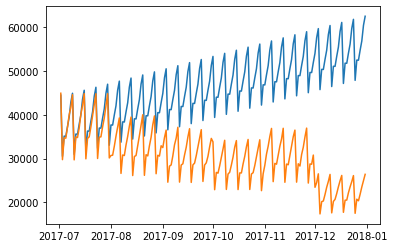

In [103]:
plt.figure()
plt.plot(val_dates, model.forecast(len(val_dates)))
plt.plot(val_dates, train.query('date > @trg_dates[-1]').groupby('date')['sales'].sum())
plt.show()

In [ ]:
train_len = np.int(0.9*len(tot_sls_trans))
train_tot_sls_trans = tot_sls_trans[:train_len]
test_tot_sls_trans = tot_sls_trans[train_len:]

In [ ]:
# Set the implied frequency of the timeseries to suppress a subsequent warning by SARIMAX()
dailysales_all.index = pd.DatetimeIndex(dailysales_all.index.values, 
                                           freq=dailysales_all.index.inferred_freq)

model = SARIMAX(dailysales_all, order = (1, 1, 1), seasonal_order = (1, 1, 1, 7), 
                trend = 'n').fit(method = 'powell')
res = model.resid

display(model.summary())

fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (13, 9), sharex = True)

tsaplots.plot_pacf(res, ax = ax1, 
                   title = 'Partial Autocorrelation Function for Residues')

tsaplots.plot_acf(res, ax = ax2,
                  title = 'Autocorrelation Function for Residues')
ax2.set_xticks(np.arange(0, 36))
ax2.set_xlabel('Lags in Days', fontsize = '12', fontweight = 'bold')

plt.show()